
# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE)

## GPU check

In [1]:
!nvidia-smi

Sun Sep 22 02:35:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install SAM and other dependencies

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 25.3 MB/s eta 0:00:00


### Download weights

In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Unzip data

In [12]:
!mkdir -p {HOME}/data
!unzip images.zip -d {HOME}/data/

Archive:  images.zip
   creating: /content/data/images/
  inflating: /content/data/__MACOSX/._images  
  inflating: /content/data/images/0058.jpg  
  inflating: /content/data/images/0048.jpg  
  inflating: /content/data/images/0049.jpg  
  inflating: /content/data/images/0012.jpg  
  inflating: /content/data/images/0006.jpg  
  inflating: /content/data/images/0007.jpg  
  inflating: /content/data/images/0013.jpg  
  inflating: /content/data/images/0005.jpg  
  inflating: /content/data/images/0011.jpg  
  inflating: /content/data/images/0039.jpg  
  inflating: /content/data/images/0038.jpg  
  inflating: /content/data/images/0010.jpg  
  inflating: /content/data/images/0004.jpg  
  inflating: /content/data/images/0028.jpg  
  inflating: /content/data/images/0014.jpg  
  inflating: /content/data/images/0015.jpg  
  inflating: /content/data/images/0001.jpg  
  inflating: /content/data/images/0029.jpg  
  inflating: /content/data/images/0017.jpg  
  inflating: /content/data/images/0003.jpg

## Load Model

In [7]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Automated Mask Generation


In [9]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
import os

!mkdir -p {HOME}/data/mask
image_paths = []
directory_path = os.path.join(HOME, "data", "images")

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(directory_path, image_name)
    image_paths.append(image_path)
    # print(image_path)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv
import numpy as np
npy_files = []

for image_name in image_files:
    npy_file_name = image_name.replace('.jpg', '.npy')
    # print(npy_file_name)
    npy_files.append(npy_file_name)
i = 0
for img_path in image_paths:
  image_bgr = cv2.imread(img_path)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  sam_result = mask_generator.generate(image_rgb)
  mask = sam_result[0]['segmentation'].astype(int)

  save_path = os.path.join(HOME, 'data', 'mask', npy_files[i])
  np.save(save_path, mask)
  i+=1

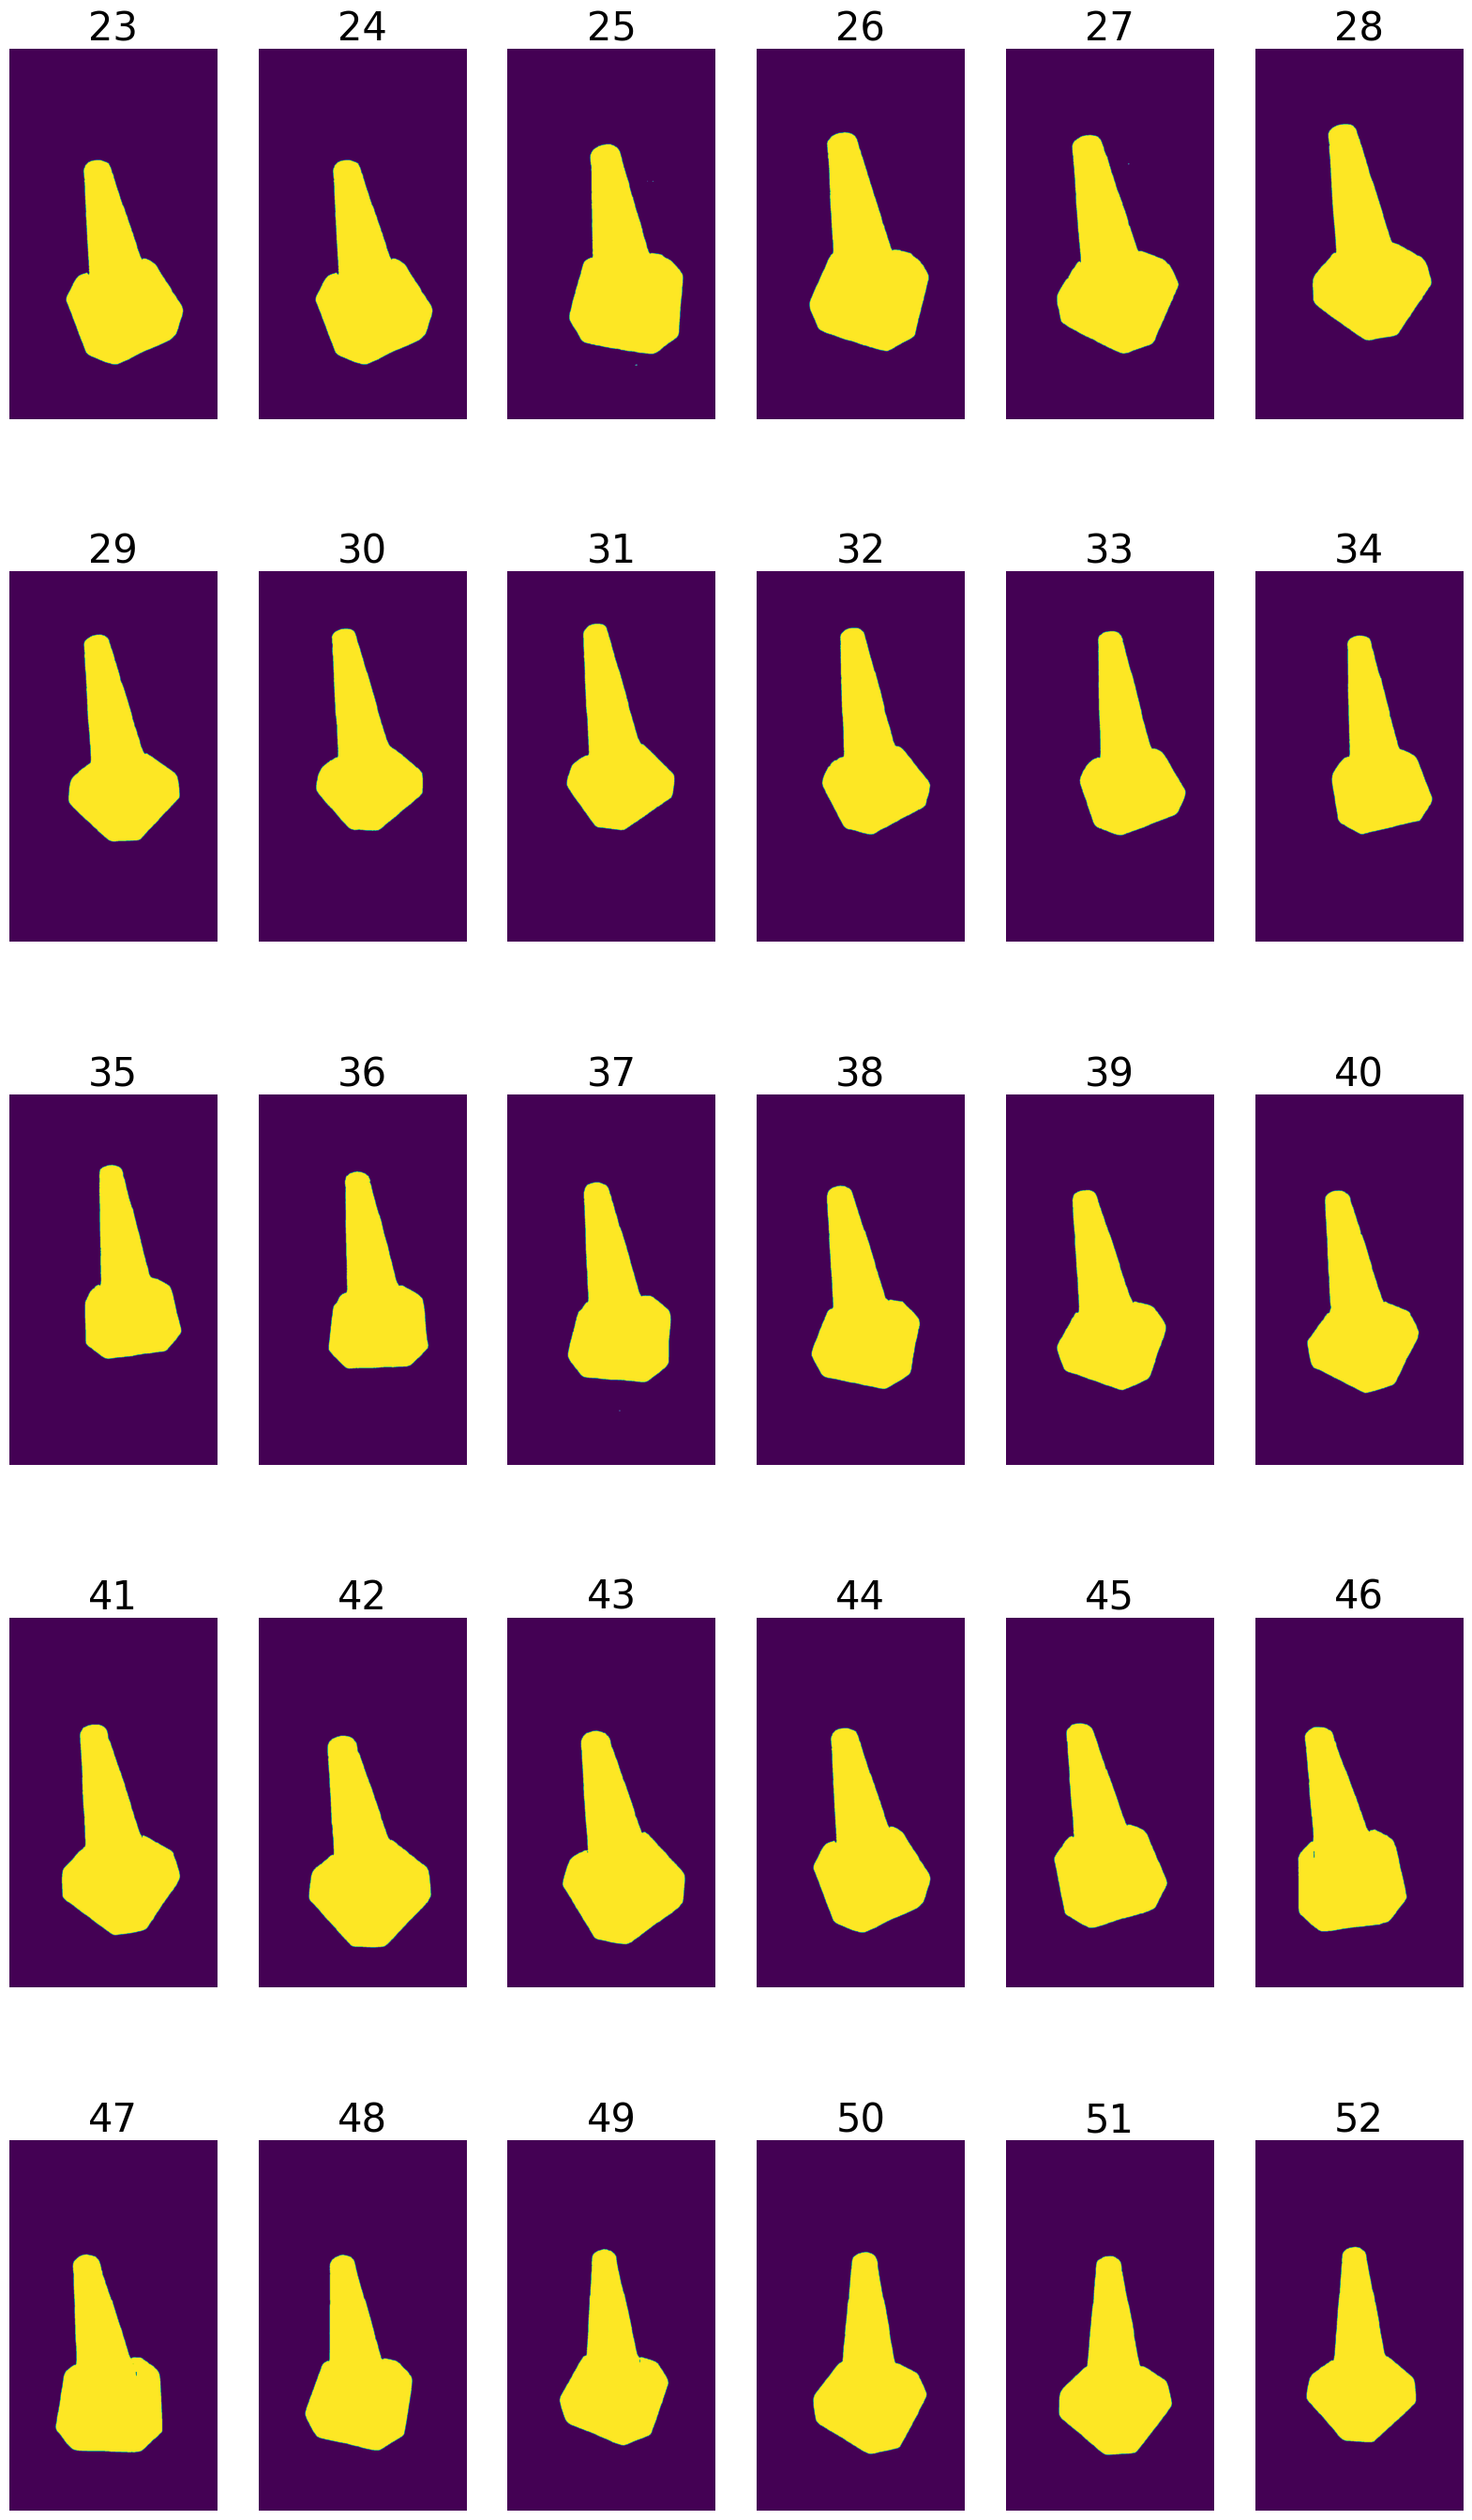

In [149]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 35))
i=23
for i in range(23,53):
  mask_path = os.path.join(HOME, 'data', 'mask_box_area_sort2', '00'+str(i)+'.npy')
  test=np.load(mask_path)[0]
  plt.subplot(5,6,i-22)
  plt.imshow(test)
  plt.title(str(i),fontsize=30)
  plt.axis('off')
  i+=1
plt.show()

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [15]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


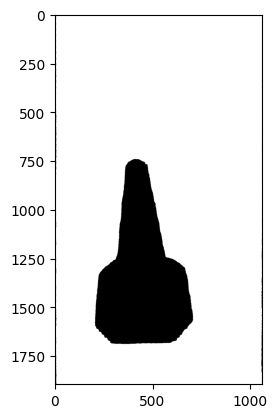

In [34]:
import matplotlib.pyplot as plt
print(sam_result[0]['segmentation'])
plt.figure()
plt.imshow(sam_result[0]['segmentation'],cmap='gray', clim=(0, 1))
plt.show()

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

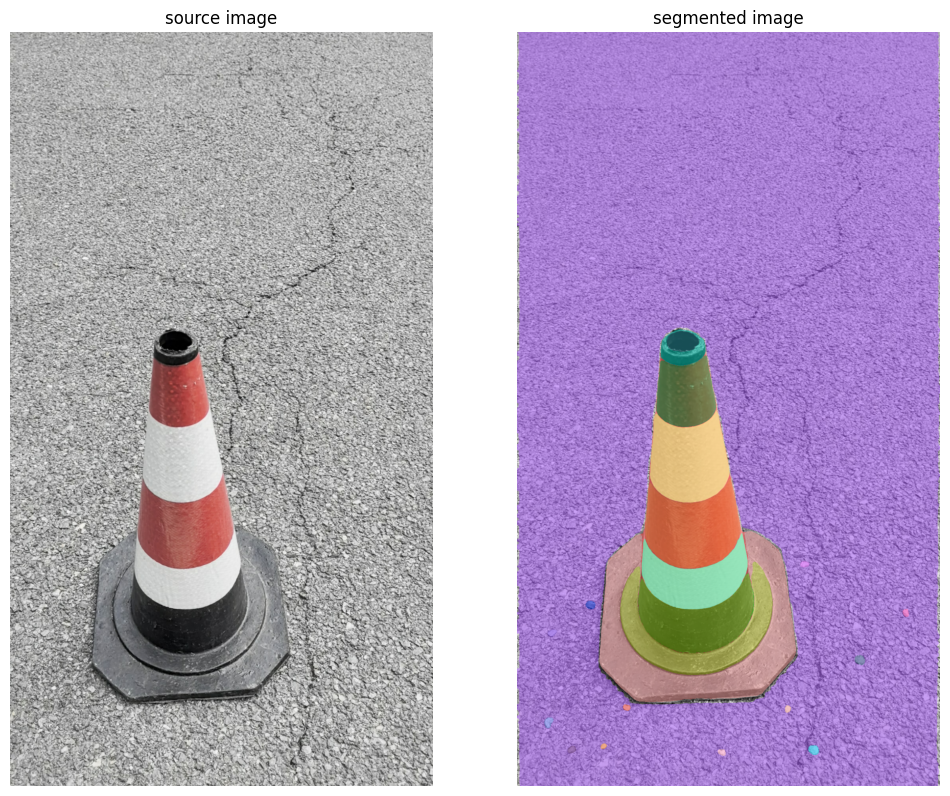

In [16]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [77]:
mask_predictor = SamPredictor(sam)

In [128]:
import os

IMAGE_NAME = "0024.jpg"
IMAGE_PATH = os.path.join(HOME, "data", "images", IMAGE_NAME)

### Draw Box



In [38]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [123]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [124]:
widget.bboxes

[{'x': 273, 'y': 566, 'width': 749, 'height': 1120, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [126]:
import numpy as np
from jupyter_bbox_widget import BBoxWidget
# default_box is going to be used if you will not draw any box on image above
# default_box = {'x': 50, 'y': 700, 'width': 836, 'height': 1237, 'label': ''}
# widget = BBoxWidget()
box = widget.bboxes[0] if widget.bboxes else default_box
# box = {'x': 263, 'y': 283, 'width': 607, 'height': 1372, 'label': ''}
# box = default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])
print(box)

[ 273  566 1022 1686]


In [108]:
import cv2
import numpy as np
import supervision as sv

!mkdir -p {HOME}/data/mask_box_area_sort2
!mkdir -p {HOME}/data/result_box_area_sort2

npy_files = []
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

for image_name in image_files:
    npy_file_name = image_name.replace('.jpg', '.npy')
    # print(npy_file_name)
    npy_files.append(npy_file_name)

i = 0
for img_path in image_paths:
  print(int(image_files[i].replace(".jpg","")))
  if int(image_files[i].replace(".jpg",""))==23:
    i+=1
    continue
  image_bgr = cv2.imread(img_path)
  # image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  mask_predictor.set_image(image_bgr)

  masks, scores, logits = mask_predictor.predict(
      box=box,
      multimask_output=True
  )
  detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
  )
  # detections = detections[detections.area == np.max(detections.area)]
  detections = detections[-1]

  # save image
  source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
  segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
  combined_image = np.hstack((source_image, segmented_image))

  save_image_path = os.path.join(HOME, 'data', 'result_box_area_sort2', image_files[i])
  print(save_image_path)
  # cv2.imwrite(save_image_path, cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
  cv2.imwrite(save_image_path,combined_image)
  save_path = os.path.join(HOME, 'data', 'mask_box_area_sort2', npy_files[i])
  np.save(save_path, detections.mask)
  i+=1


13
9
39
/content/data/result_box_area_sort2/0039.jpg
48
/content/data/result_box_area_sort2/0048.jpg
16
33
/content/data/result_box_area_sort2/0033.jpg
5
6
57
/content/data/result_box_area_sort2/0057.jpg
26
/content/data/result_box_area_sort2/0026.jpg
29
/content/data/result_box_area_sort2/0029.jpg
43
/content/data/result_box_area_sort2/0043.jpg
22
47
/content/data/result_box_area_sort2/0047.jpg
12
55
/content/data/result_box_area_sort2/0055.jpg
53
/content/data/result_box_area_sort2/0053.jpg
45
/content/data/result_box_area_sort2/0045.jpg
54
/content/data/result_box_area_sort2/0054.jpg
52
/content/data/result_box_area_sort2/0052.jpg
30
/content/data/result_box_area_sort2/0030.jpg
56
/content/data/result_box_area_sort2/0056.jpg
3
23
/content/data/result_box_area_sort2/0023.jpg
28
/content/data/result_box_area_sort2/0028.jpg
32
/content/data/result_box_area_sort2/0032.jpg
4
7
51
/content/data/result_box_area_sort2/0051.jpg
38
/content/data/result_box_area_sort2/0038.jpg
10
18
27
/conten

In [129]:
!zip -r data.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/result_box_area_sort2/ (stored 0%)
  adding: content/data/result_box_area_sort2/0039.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0048.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0033.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0057.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0026.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0029.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0043.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0047.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0055.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0053.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0045.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0054.jpg (deflated 1%)
  adding: content/data/result_box_area_sort2/0052.jpg (deflated 1%)
  adding: content/data

### Results visualisation with Supervision

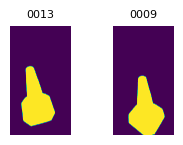

In [118]:
import matplotlib.pyplot as plt
plt.figure()
i=1
for img_path in image_paths:
  if i == 3:
    break
  mask_path = img_path.replace('images','mask_box_area_sort').replace('jpg','npy')
  test=np.load(mask_path)[0]
  plt.subplot(3,5,i)
  plt.imshow(test)
  plt.title(str(image_files[i-1].replace('.jpg','')),fontsize=8)
  plt.axis('off')
  i+=1
plt.show()

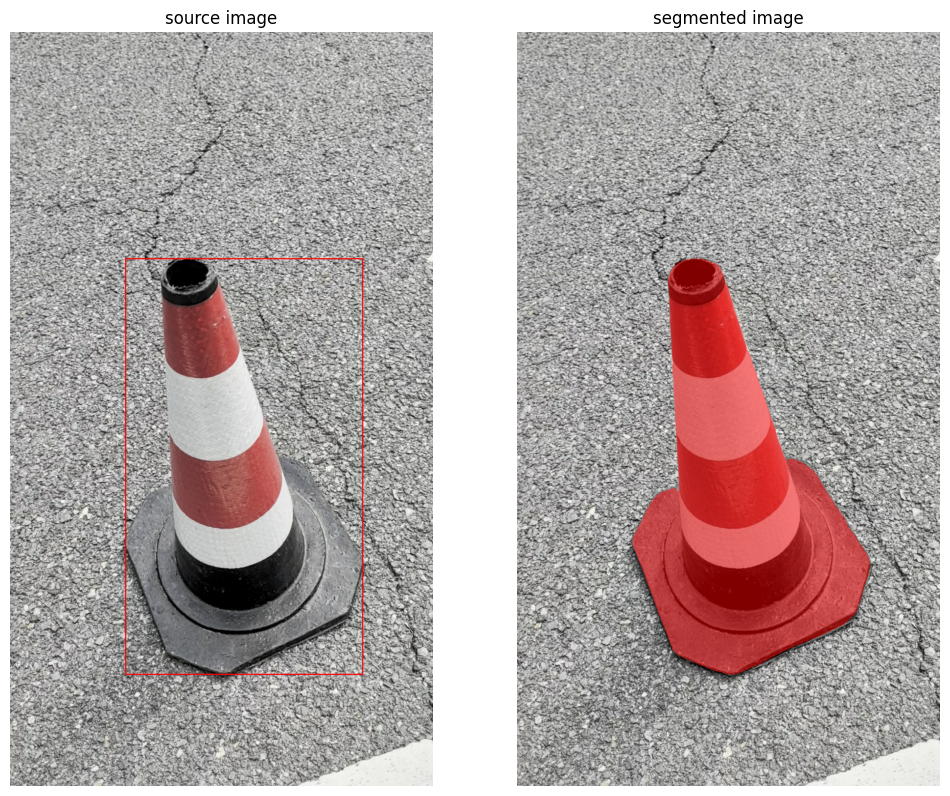

/content/data/result_box_area_sort2/0024.jpg


In [127]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

combined_image = np.hstack((source_image, segmented_image))

save_image_path = os.path.join(HOME, 'data', 'result_box_area_sort2', IMAGE_NAME)
print(save_image_path)
# cv2.imwrite(save_image_path, cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
cv2.imwrite(save_image_path,combined_image)
save_path = os.path.join(HOME, 'data', 'mask_box_area_sort2', IMAGE_NAME.replace(".jpg",".npy"))
np.save(save_path, detections.mask)

### Interaction with segmentation results

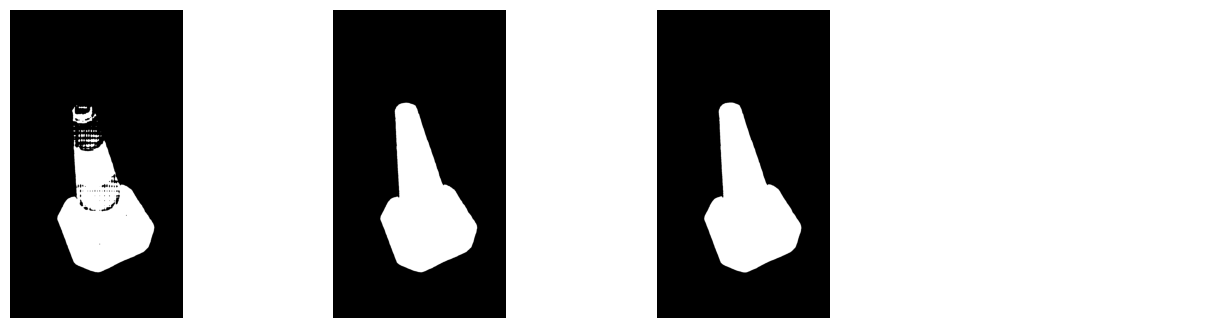

In [121]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)